In [89]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

from sympy.utilities.autowrap import autowrap

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mpc
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['text.usetex'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = "#cdcdcd"
mpl.rcParams['grid.linestyle'] = ":"
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#767afe", "#2b926a", "#b53546", "#e78b50", "#b462be"]) 
mpl.rcParams['font.family'] = 'cmr10'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.formatter.use_mathtext'] = True

from astropy import constants, units

from scipy.integrate import quad, solve_ivp
from scipy.optimize import fsolve

from time import time

%matplotlib widget

In [107]:
# Interface to LineCollection:
def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


def colorline(ax, x, y, z=None, cmap=plt.get_cmap('winter'), norm=plt.Normalize(0.0, 1.0), linewidth=1, alpha=1.0) -> LineCollection:
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax.add_collection(lc)
    
    return lc

# Defining constants and functions for the equation of state

In [20]:
# Constants

Gamma = 5/3
k = 3.261e-95
mu_0 = constants.m_n.to('Msun').value

In [34]:
def p(chi_mu):
    return k*((mu_0/k)*(1-1/Gamma)*(np.exp(chi_mu)-1))**(Gamma/(Gamma-1))

def mu(chi_mu):
    return mu_0*np.exp(chi_mu)

def n(p):
    return (p/k)**(1/Gamma)

def epsilon(chi_mu):
    pp = p(chi_mu)
    return mu(chi_mu)*n(pp)-pp

In [37]:
def du_dchi(chi, u, v, chi_c):
    if chi == chi_c:
        return -3/(2*np.pi*(epsilon(chi)+3*p(chi)))
    else:
        return -2*u*(1-2*v)/(4*np.pi*u*p(chi)+v)
        

In [38]:
def dv_dchi(chi, u, v, chi_c):
    if chi == chi_c:
        return -2*epsilon(chi)/(epsilon(chi)+3*p(chi))
    else:
        return -(1-2*v)*(4*np.pi*u*epsilon(chi)-v)/(4*np.pi*u*p(chi)+v)
        

In [39]:
def update_state(chi, state, chi_c):
    u, v = state
    
    return du_dchi(chi, u, v, chi_c), dv_dchi(chi, u, v, chi_c)

In [203]:
def solve_tov(chi_c):

    sol = solve_ivp(lambda chi, state: update_state(chi, state, chi_c), [chi_c, 0], [0, 0], rtol = 1e-12, atol = 1e-8)

    chi_mu, u, v = sol.t, sol.y[0], sol.y[1]

    r = np.sqrt(u)
    m = r*v
    
    return {'chi_c': chi_c, 'chi_mu': chi_mu, 'r': r, 'm': m}

# Testing the algorithm for $\chi_{\mu c} = 0.1$

In [204]:
chi_c = 0.1

tov_sol = solve_tov(chi_c)

r, m, chi_mu = tov_sol['r'], tov_sol['m'], tov_sol['chi_mu']

R, M = r[-1], m[-1]

alpha = np.sqrt(1-2*m[-1]/r[-1])/np.exp(chi_mu)

/var/folders/nc/r976xvfd307_rr033_4j2cz00000gn/T/ipykernel_28192/3695423726.py:11: RuntimeWarning: divide by zero encountered in divide
  exteriors_schwarzschild_g00 = 1-2*M/exteriors_schwarzschild_r


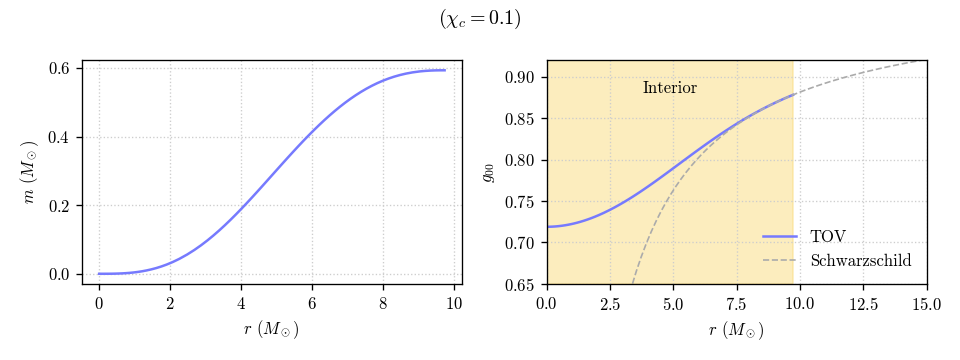

In [205]:
plt.close('all')

fig, axs = plt.subplots(1, 2, figsize = (8, 3))

axs[0].plot(r, m)

axs[0].set_xlabel(r'$r$ ($M_\odot$)')
axs[0].set_ylabel(r'$m$ ($M_\odot$)')

exteriors_schwarzschild_r = np.linspace(0, 2*R, 100)
exteriors_schwarzschild_g00 = 1-2*M/exteriors_schwarzschild_r

axs[1].set_xlabel(r'$r$ ($M_\odot$)')
axs[1].set_ylabel(r'$g_{00}$')

axs[1].plot(r, alpha**2, label = "TOV")
axs[1].plot(exteriors_schwarzschild_r, exteriors_schwarzschild_g00, linestyle = '--', linewidth = 1, color = "#ababab", label = "Schwarzschild")

axs[1].axvspan(0, R, color = "#fadc7e", alpha = 0.5)

axs[1].set_ylim(0.65, 0.92)
axs[1].set_xlim(0, 15)

axs[1].text(R/2, 0.88, "Interior", ha = "center")

axs[1].legend(loc = 4)

fig.suptitle(r"$(\chi_c = 0.1)$")
fig.tight_layout()


# Mass vs. radius relation for $\chi_{\mu c} \in [0.01, 10]$

In [206]:
chi_c_arr = np.logspace(-2, 1, 400)

tov_arr = []

for chi_c in chi_c_arr:
    tov_arr.append(solve_tov(chi_c))

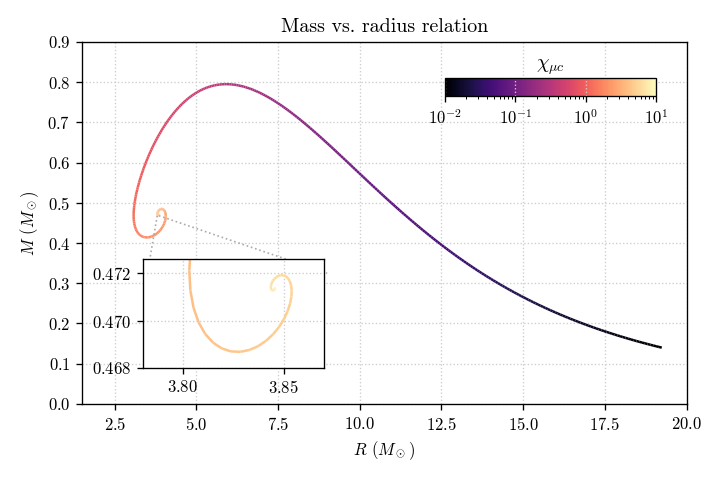

In [209]:
plt.close('all')

fig, ax = plt.subplots(figsize = (6,4))

R_arr = [tov['r'][-1] for tov in tov_arr]
M_arr = [tov['m'][-1] for tov in tov_arr]

cmap = plt.get_cmap('magma')
norm = mpc.LogNorm(vmin = chi_c_arr[0], vmax = chi_c_arr[-1])
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
lc = colorline(ax, R_arr, M_arr, chi_c_arr, linewidth = 1.5, norm = norm, cmap = cmap)

ax.set_xlim(1.5, 20)
ax.set_ylim(0, 0.9)

ax_cbar = ax.inset_axes((0.6, 0.85, 0.35, 0.05))
cbar = fig.colorbar(mappable, cax = ax_cbar, orientation = 'horizontal')
ax_cbar.set_title(r'$\chi_{\mu c}$')

ax.set_xlabel(r'$R$ ($M_\odot$)')
ax.set_ylabel(r'$M$ ($M_\odot$)')

ax.set_title("Mass vs. radius relation")

# Zoom axis

ax_zoom = ax.inset_axes((0.1, 0.1, 0.3, 0.3))
lc = colorline(ax_zoom, R_arr, M_arr, chi_c_arr, linewidth = 1.5, norm = norm, cmap = cmap)
ax_zoom.set_xlim(3.78, 3.87)
ax_zoom.set_ylim(0.468, 0.4726)

# Zoom "lines"

ax.plot([3.80, 3.5], [0.468, 0.325], color = '#ababab', linestyle = ':', linewidth = 1)
ax.plot([3.85, 9], [0.468, 0.325], color = '#ababab', linestyle = ':', linewidth = 1)


fig.tight_layout()